In [5]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
%matplotlib inline

In [165]:
#Reading in the data
data = np.load('../data/same_preset_YN_40_5_4.npz.npy')
trueCls = np.load('../data/same_preset_MC_40_5_4_reference_classes.npy')
data.shape

(40, 5, 4, 2)

In [166]:
#Inferring the number of classes and data length
numData = data.shape[0]
numExperts = data.shape[1]
numClasses = data.shape[2]

In [167]:
def swap_class(z, row_idx, numClasses):
    new_z = np.copy(z)
    classes = list(range(numClasses))
    old_class = np.where(z[row_idx,:] == 1)[0][0]
    #Removing the old class
    del classes[old_class]
    new_class = np.random.choice(classes)
    new_row = np.zeros(numClasses)
    new_row[new_class] = 1.
    new_z[row_idx] = new_row
    return new_z

In [168]:
def gen_confusion_matrix(z, data):
    numClasses = data.shape[2]
    numData = data.shape[0]
    confMat = 0.01*np.ones((numClasses, numClasses))
    for data_idx in range(numData):
        dat = data[data_idx]
        data_val = np.sum(dat, axis=0)
        observed_cls = z[data_idx,:]
        class_num = np.where(observed_cls == 1)[0][0]
        confMat[class_num,:] += data_val[:,1]
    confMat = confMat/np.sum(confMat, axis=1)[:, np.newaxis]
    return confMat

In [169]:
def mc_likelihood(value=data, z=z, confMatHat=confMat):
    """
    value - data
    z - observed classes
    confMat - confidence matrix
    """
    log_like = 0
    numData = data.shape[0]
    numExperts = data.shape[1]
    numClasses = data.shape[2]
    for data_idx in range(numData):
        dat = data[data_idx]
        observed_cls = z[data_idx]
        class_num = np.where(observed_cls == 1)[0][0]
        data_val = np.sum(dat, axis=0)
        computed_val = np.sum(np.multiply(data_val[:,1], np.log(confMatHat[class_num]))) + \
                        np.sum(np.multiply(data_val[:,0], np.log(1-confMatHat[class_num])))
        log_like += np.sum(np.multiply(observed_cls, computed_val))
    
    return log_like

In [170]:
"""
#Randomly generating the z's
data_num = np.random.choice(range(numClasses), size=numData)
z = np.eye(numClasses)[data_num]
"""
inferred_labels = np.argmax(data.sum(axis=1)[:,:,1], axis=1)
z = np.eye(numClasses)[inferred_labels]
confMat = gen_confusion_matrix(z, data)

In [171]:
def simulated_annealing_mc(z, confMat, data, starting_temp=1, reanneal=0.1, num_iterations=100):
    #Inferring the number of classes and data length
    numData = data.shape[0]
    numExperts = data.shape[1]
    numClasses = data.shape[2]
    numAccepts = 0
    temp = starting_temp
    likelihood_trace = []
    best_likelihood_trace = []
    temp_trace = []
    best_start = z
    best_conf = confMat
    best_lik = -np.inf
    for i in range(num_iterations):
        swap_idx = np.random.choice(range(numData), size=1, replace=False)[0]
        z_new = swap_class(z, swap_idx, numClasses)
        confMatNew = gen_confusion_matrix(z_new, data)
        new_lik = mc_likelihood(data, z_new, confMatNew)
        old_lik = mc_likelihood(data, z, confMat)
        u = np.random.uniform()
        prob = min([1, np.exp((new_lik - old_lik)/temp)])
        #print prob, u
        #Always accepting if the likelihood increases
        if new_lik > old_lik:
            z = z_new
            confMat = confMatNew
            if new_lik > best_lik:
                best_lik = new_lik
                best_start = z_new
                best_conf = confMat
            likelihood_trace.append(new_lik)
            numAccepts += 1
        #Accepting based on the probability if the error does not reduce
        elif prob >= u:
            z = z_new
            confMat = confMatNew
            if new_lik > best_lik:
                best_lik = new_lik
                best_start = z
                best_conf = confMat
            likelihood_trace.append(new_lik)
            numAccepts += 1
        else:
            likelihood_trace.append(old_lik)
        #Reducing temperature every 10th iteration
        if i%10 == 0:
            temp = temp*0.99
        if i%1000 == 0:
            print "#",
        #Reannealing if the temperature is too low
        if temp < reanneal:
            temp = 1
        temp_trace.append(temp)
        best_likelihood_trace.append(best_lik)
    return likelihood_trace, best_likelihood_trace, temp_trace, best_start, best_lik, best_conf, numAccepts

In [172]:
likelihood_trace, best_likelihood_trace, temp_trace, best_start, best_lik, best_conf, numAccepts =\
simulated_annealing_mc(z, confMat, data, num_iterations=10000)

# # # # # # # # # #


#### Using Harder Datasets

#### For extrahard_YN_40_5_4.npz.npy

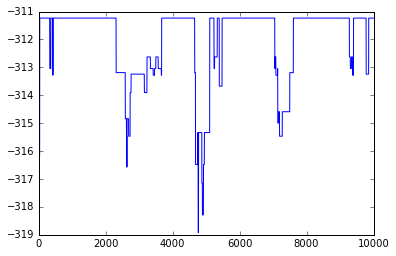

In [135]:
plt.plot(likelihood_trace)

In [136]:
print "Accuracy :", np.sum(np.argmax(best_start, axis=1) == trueCls)*100/numData, "%"

Accuracy : 97 %


In [137]:
best_conf

array([[ 0.80899144,  0.04781161,  0.09538535,  0.04781161],
       [ 0.0639881 ,  0.63796769,  0.14902211,  0.14902211],
       [ 0.04272959,  0.14902211,  0.65922619,  0.14902211],
       [ 0.0962721 ,  0.05784012,  0.13470407,  0.7111837 ]])

#### For extrahard_YN_80_5_4.npz.npy

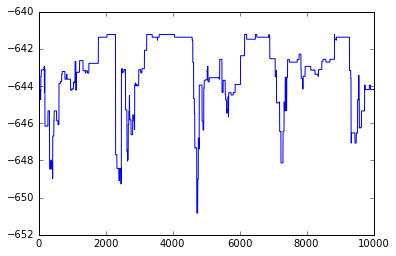

In [146]:
plt.plot(likelihood_trace)

In [147]:
print "Accuracy :", np.sum(np.argmax(best_start, axis=1) == trueCls)*100/numData, "%"

Accuracy : 92 %


In [148]:
best_conf

array([[ 0.67659532,  0.13136107,  0.11116721,  0.08087641],
       [ 0.11256872,  0.76224388,  0.05009995,  0.07508746],
       [ 0.12967419,  0.09265087,  0.70353573,  0.07413921],
       [ 0.11822973,  0.13640494,  0.10914213,  0.63622319]])

#### For extrahard_YN_100_5_4.npz.npy

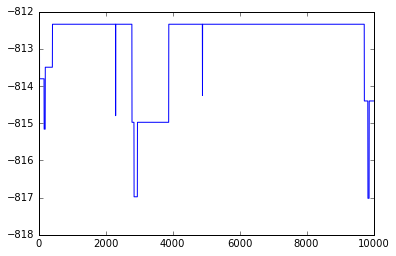

In [98]:
plt.plot(likelihood_trace)

In [99]:
print "Accuracy :", np.sum(np.argmax(best_start, axis=1) == trueCls)*100/numData, "%"

Accuracy : 99 %


In [100]:
best_conf

array([[ 0.62400737,  0.12060408,  0.15605502,  0.09933352],
       [ 0.10691392,  0.6868895 ,  0.12980769,  0.07638889],
       [ 0.14507021,  0.05349512,  0.70215201,  0.09928266],
       [ 0.05474852,  0.10941893,  0.10941893,  0.72641362]])

#### For extrahard_YN_200_5_4.npz.npy

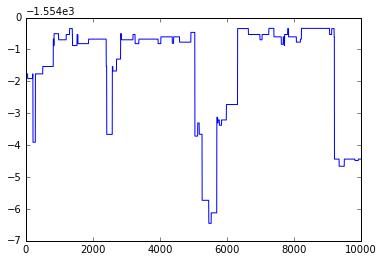

In [109]:
plt.plot(likelihood_trace)

In [110]:
print "Accuracy :", np.sum(np.argmax(best_start, axis=1) == trueCls)*100/numData, "%"

Accuracy : 96 %


In [111]:
best_conf

array([[ 0.72341312,  0.13638085,  0.06442206,  0.07578397],
       [ 0.11205609,  0.70531862,  0.09546133,  0.08716396],
       [ 0.09377441,  0.10549133,  0.69524293,  0.10549133],
       [ 0.0916587 ,  0.10360899,  0.09564213,  0.70909018]])

#### For extrahard_YN_500_5_4.npz.npy

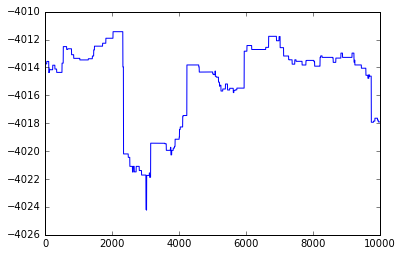

In [120]:
plt.plot(likelihood_trace)

In [121]:
print "Accuracy :", np.sum(np.argmax(best_start, axis=1) == trueCls)*100/numData, "%"

Accuracy : 96 %


In [122]:
best_conf

array([[ 0.67648883,  0.09749793,  0.10045197,  0.12556127],
       [ 0.09236673,  0.70538501,  0.09873575,  0.10351252],
       [ 0.10244862,  0.12033364,  0.69428005,  0.0829377 ],
       [ 0.0946947 ,  0.08638961,  0.12127101,  0.69764467]])

#### Using Preset Datasets

#### For same_preset_YN_500_5_4.npz.npy

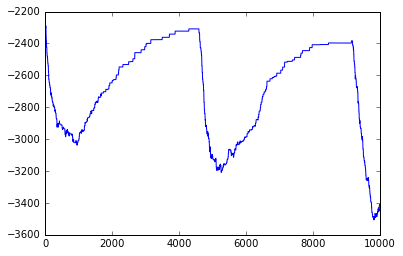

In [74]:
plt.plot(likelihood_trace)

In [75]:
print "Accuracy :", np.sum(np.argmax(best_start, axis=1) == trueCls)*100/numData, "%"

Accuracy : 99 %


In [76]:
best_conf

array([[ 0.85820597,  0.05548194,  0.0369931 ,  0.04931899],
       [ 0.04362657,  0.87223537,  0.04051149,  0.04362657],
       [ 0.03619828,  0.03455365,  0.88318203,  0.04606605],
       [ 0.05137712,  0.04174692,  0.04495699,  0.86191898]])

#### For same_preset_YN_200_5_4.npz.npy

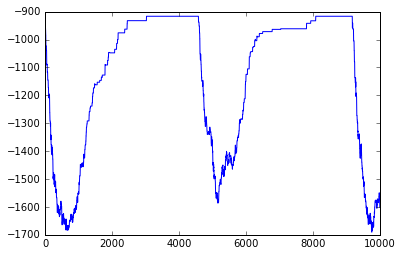

In [63]:
plt.plot(likelihood_trace)

In [64]:
print "Accuracy :", np.sum(np.argmax(best_start, axis=1) == trueCls)*100/numData, "%"

Accuracy : 100 %


In [65]:
best_conf

array([[ 0.87018909,  0.04187584,  0.03350904,  0.05442604],
       [ 0.03589069,  0.8763942 ,  0.04385755,  0.04385755],
       [ 0.02792384,  0.03987412,  0.88037763,  0.05182441],
       [ 0.03546686,  0.03546686,  0.07089435,  0.85817194]])

#### For same_preset_YN_100_5_4.npz.npy

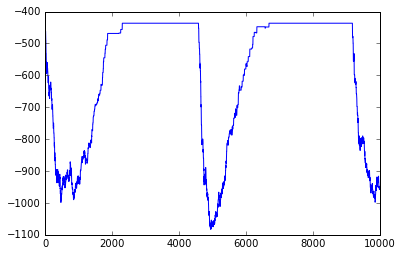

In [52]:
plt.plot(likelihood_trace)

In [53]:
print "Accuracy :", np.sum(np.argmax(best_start, axis=1) == trueCls)*100/numData, "%"

Accuracy : 100 %


In [54]:
best_conf

array([[ 0.87076749,  0.02426637,  0.06457594,  0.0403902 ],
       [ 0.06928637,  0.83059059,  0.05390649,  0.04621655],
       [ 0.03131834,  0.0391284 ,  0.88261481,  0.04693846],
       [ 0.03131834,  0.0391284 ,  0.02350828,  0.90604499]])

#### For same_preset_YN_40_5_4.npz.npy

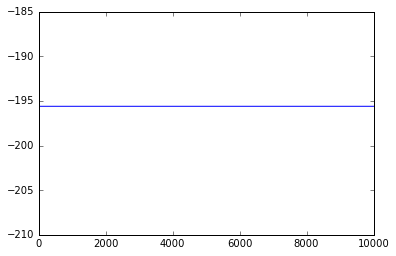

In [173]:
plt.plot(likelihood_trace)

In [174]:
print "Accuracy :", np.sum(np.argmax(best_start, axis=1) == trueCls)*100/numData, "%"

Accuracy : 100 %


In [175]:
best_conf

array([[  8.48604827e-01,   1.13310709e-01,   1.90422323e-02,
          1.90422323e-02],
       [  7.85658307e-02,   8.62264890e-01,   5.89733542e-02,
          1.95924765e-04],
       [  5.37116345e-02,   7.15560314e-02,   8.38865096e-01,
          3.58672377e-02],
       [  3.46312888e-02,   1.55237767e-01,   3.46312888e-02,
          7.75499655e-01]])

#### For same_preset_YN_80_5_4.npz.npy

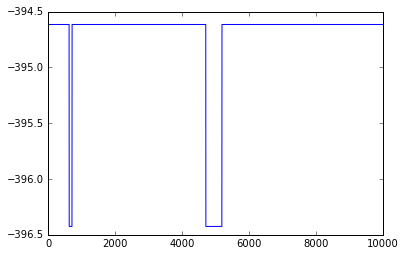

In [162]:
plt.plot(likelihood_trace)

In [163]:
print "Accuracy :", np.sum(np.argmax(best_start, axis=1) == trueCls)*100/numData, "%"

Accuracy : 100 %


In [164]:
best_conf

array([[ 0.84290474,  0.05889847,  0.02949824,  0.06869855],
       [ 0.03039176,  0.87853393,  0.02029483,  0.07077948],
       [ 0.04048869,  0.03039176,  0.84824313,  0.08087641],
       [ 0.05889847,  0.04909839,  0.04909839,  0.84290474]])